In [1]:
import cv2
import numpy as np
import glob
import Quartz
import Vision
import CoreFoundation
from Cocoa import NSURL
from Foundation import NSDictionary, NSArray
import matplotlib.pyplot as plt

import requests as req

from glob import glob
from tqdm import tqdm
from pathlib import Path

In [2]:
def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)


def scan(img, name=""):
    # Resize image to workable size
    dim_limit = 1920
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    candidates = []
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(corners)
        # If our approximated contour has four points.
        if len(corners) == 4:
            candidates.append((corners, area))
    if len(candidates) == 0:
        return orig_img
    candidates.sort(key=lambda x: x[1], reverse=True)
    corners = candidates[0][0]
    print(candidates)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(
        np.float32(corners), np.float32(destination_corners)
    )
    # Perspective transform using homography.
    final = cv2.warpPerspective(
        orig_img,
        M,
        (destination_corners[2][0], destination_corners[2][1]),
        flags=cv2.INTER_LINEAR,
    )
    return final

In [3]:
imgs = glob("figures/posters/*.png")
# for img in tqdm(imgs):
#     print(img)
#     img_dat=cv2.imread(img)
#     final=scan(img_dat)
#     cv2.imwrite('out/'+img.split('/')[-1], final)

In [4]:
def make_request_handler_img(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations: "list[Vision.VNRecognizedTextObservation]" = request.results()
            for text_observation in observations:
                recognized_text = text_observation.topCandidates_(1)[0]
                corners = {
                    "tl": text_observation.topLeft(),
                    "tr": text_observation.topRight(),
                    "bl": text_observation.bottomLeft(),
                    "br": text_observation.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    [recognized_text.string(), recognized_text.confidence(), corners]
                )

    return handler


def image_to_text(
    img_path, lang="eng"
) -> "list[tuple[str, float, dict[str,tuple[float,float]]]]":
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_img(results)
    vision_request = Vision.VNRecognizeTextRequest.alloc().initWithCompletionHandler_(
        handler
    )
    # print(vision_request.recognitionLanguages())
    vision_request.setRecognitionLanguages_(
        NSArray.arrayWithArray_(
            [
                lang,
            ]
        )
    )
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    vision_request.setUsesCPUOnly_(False)  # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results

In [5]:
def find_dest_doc(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [
        [0, 0],
        [0, maxHeight],
        [maxWidth, 0],
        [maxWidth, maxHeight],
    ]

    return destination_corners


def make_request_handler_doc(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations = request.results()
            for obs in observations:
                # print(obs)
                # print(obs.bottomLeft())
                # print(obs.bottomRight())
                bbox = obs.boundingBox()
                corners = {
                    "tl": obs.topLeft(),
                    "tr": obs.topRight(),
                    "bl": obs.bottomLeft(),
                    "br": obs.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    {
                        "bbox": corners,
                        "bbox_obj": bbox,
                        "conf": obs.confidence(),
                    }
                )

    return handler


def image_doc_handler(img_path: str) -> str:
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_doc(results)
    vision_request = (
        Vision.VNDetectDocumentSegmentationRequest.alloc().initWithCompletionHandler_(
            handler
        )
    )
    # print(vision_request.recognitionLanguages())
    # vision_request.setRecognitionLanguages_(NSArray.arrayWithArray_([lang,]))
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    # vision_request.setUsesCPUOnly_(False) # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results


res = image_doc_handler(imgs[0])
res

[{'bbox': {'tl': (0.1458333283662796, 0.703125),
   'tr': (0.7222222089767456, 0.8046875),
   'bl': (0.1805555522441864, 0.15234375),
   'br': (0.7291666865348816, 0.08203125)},
  'bbox_obj': <CoreFoundation.CGRect origin=<CoreFoundation.CGPoint x=0.1458333283662796 y=0.08203125> size=<CoreFoundation.CGSize width=0.583333358168602 height=0.72265625>>,
  'conf': 0.9444800615310669}]

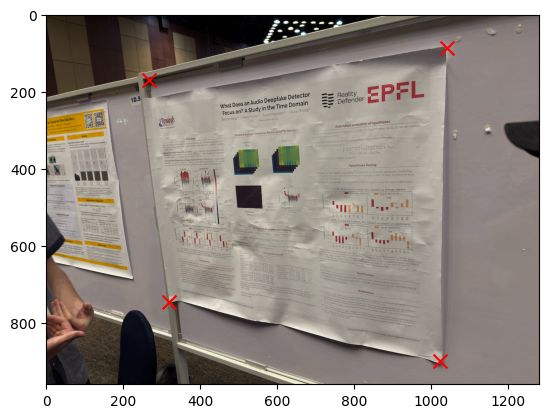

In [6]:
img = imgs[1]
res = image_doc_handler(img)
img_dat = cv2.imread(img)
src = np.array([list(p) for p in res[0]["bbox"].values()])
dst = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
shape = np.flip(img_dat.shape[:2])
src = src * shape
dst_scaled = find_dest_doc(src)
src_flipped_y = np.copy(src)
src_flipped_y[:, 1] = shape[1] - src[:, 1]
plt.imshow(cv2.cvtColor(img_dat, cv2.COLOR_BGR2RGB))
plt.scatter(src_flipped_y[:, 0], src_flipped_y[:, 1], marker="x", color="red", s=100)

In [7]:
dst_scaled

[[0, 0], [0, 1051], [777, 0], [777, 1051]]

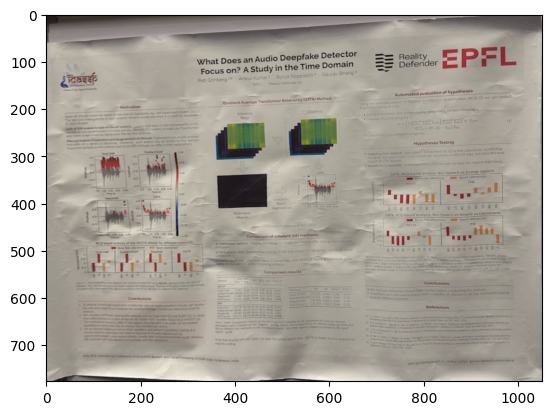

In [8]:
dst_mtx= np.array(dst_scaled).astype("float32")
src_mtx = np.array(src_flipped_y).astype("float32")
M = cv2.getPerspectiveTransform(src_mtx, np.flip(dst_mtx,axis=-1))
dst_size=tuple(np.flip(dst_mtx.max(axis=0)).astype('int').tolist())

warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
# warped_flipped=cv2.
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [9]:
def extract_poster_img(img: str):
    res = image_doc_handler(img)
    img_dat = cv2.imread(img)
    src = np.array([list(p) for p in res[0]["bbox"].values()])
    shape = np.flip(img_dat.shape[:2])
    src = src * shape
    dst_scaled = find_dest_doc(src)
    src_flipped_y = np.copy(src)
    src_flipped_y[:, 1] = shape[1] - src[:, 1]

    dst_mtx = np.array(dst_scaled).astype("float32")
    src_mtx = np.array(src_flipped_y).astype("float32")
    M = cv2.getPerspectiveTransform(src_mtx, np.flip(dst_mtx, axis=-1))
    dst_size = tuple(np.flip(dst_mtx.max(axis=0)).astype("int").tolist())

    warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
    return warped


for img in tqdm(imgs):
    img_path = Path(img)
    warped = extract_poster_img(img)
    target_path = img_path.parent / "warped" / img_path.parts[-1]

    cv2.imwrite(str(target_path), warped)

100%|██████████| 44/44 [00:04<00:00,  9.80it/s]


In [10]:
target_path

PosixPath('figures/posters/warped/IMG_2746.png')

In [11]:
def authors_text(texts):
    results = texts
    for textbox in results:
        commas = (
            textbox[0].count(",")
            + textbox[0].count("and")
            + textbox[0].count("&")
            + textbox[0].count(".")
        )

        textbox.append(commas)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""


def biggest_text(texts):
    results = texts
    for textbox in results:
        dims = textbox[2]
        poss = np.array([dims["tl"], dims["tr"], dims["br"], dims["bl"]]).astype(
            np.float32
        )
        area = cv2.contourArea(poss)
        textbox.append(area)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""

In [12]:
outs = glob("figures/posters/warped/*.png")
for img in tqdm(outs):
    img_dat = cv2.imread(img)
    # downscale image
    dim_limit = 1080
    max_dim = max(img_dat.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img_dat = cv2.resize(img_dat, None, fx=resize_scale, fy=resize_scale)
    cv2.imwrite("figures/posters/reduced/" + img.split("/")[-1], img_dat)

100%|██████████| 44/44 [00:02<00:00, 21.40it/s]


In [13]:
data = []
for img in tqdm(outs):

    texts = image_to_text(img, "eng")
    title = biggest_text(texts)
    authors = authors_text(texts)

    # print(title, authors)
    data.append({"title": title, "authors": authors, "texts": texts, "img": img})

100%|██████████| 44/44 [00:47<00:00,  1.09s/it]


In [14]:
import pandas as pd
data_df=pd.DataFrame(data)
data_df.head()

,title,authors,texts,img
0,PD-VOST: PARKINSON'S DISEASE VOICE SPECTROGRAM...,"llias Tougui, Mehdi Zakroum, Ouassim Karakchou...","[[llias Tougui, Mehdi Zakroum, Ouassim Karakch...",figures/posters/warped/IMG_2777.png
1,EPFL,"pee/ginbergaepf.ch, facia, surya, gauravia roa...","[[pee/ginbergaepf.ch, facia, surya, gauravia r...",figures/posters/warped/IMG_2748.png
2,"Michele Mancusi, Yurii Halychanskyi, Kin Wai C...","Michele Mancusi, Yurii Halychanskyi, Kin Wai C...","[[Michele Mancusi, Yurii Halychanskyi, Kin Wai...",figures/posters/warped/IMG_2749.png
3,do a crow endus ported ten band mentorine at p...,do a crow endus ported ten band mentorine at p...,[[do a crow endus ported ten band mentorine at...,figures/posters/warped/IMG_2761.png
4,EFFICETH REPARAMNE,"outperforming models like CV-SOG, Motifs, and ...","[[outperforming models like CV-SOG, Motifs, an...",figures/posters/warped/IMG_2758.png


In [15]:
data_df["url"]=""

In [16]:
%pip install scholarly serpapi

Note: you may need to restart the kernel to use updated packages.


In [17]:
from scholarly import scholarly, ProxyGenerator
pg = ProxyGenerator()
pg.ScraperAPI("efa5c73f2a21f894725ed312cfaad009")
scholarly.use_proxy(pg)
import time

TypeError: Client.__init__() got an unexpected keyword argument 'proxies'

In [ ]:
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    params = {
        "engine": "google_scholar",
        "q":  row["title"],
        "api_key": "98ed7415edad5f6a67a50ea79561afec7a4006825545742f9fd296689aaf9341",
    }

    search = req.get(
        "https://serpapi.com/search",
        params=params,
    )
    search=search.json()
    if "organic_results" not in search:
        print("No results found")
        continue
    results = search["organic_results"]
    pub = results[0]
    data_df.loc[i, "url"] = pub["link"]
    data_df.loc[i, "title"] = pub["title"]

  9%|▉         | 4/44 [00:13<02:35,  3.88s/it]

No results found


 11%|█▏        | 5/44 [00:13<01:50,  2.83s/it]

No results found


 43%|████▎     | 19/44 [00:38<00:26,  1.05s/it]

No results found


 52%|█████▏    | 23/44 [00:50<00:40,  1.91s/it]

No results found


 73%|███████▎  | 32/44 [01:07<00:21,  1.81s/it]

No results found


100%|██████████| 44/44 [01:35<00:00,  2.17s/it]


In [ ]:
data_df.tail()

,title,authors,texts,img,url
39,Glial‐neuronal interactions in Alzheimer's dis...,"hutcmoshini001@Bentuedusg, choc0010@e.ntu.edus...","[[hutcmoshini001@Bentuedusg, choc0010@e.ntu.ed...",figures/posters/warped/IMG_2747.png,https://onlinelibrary.wiley.com/doi/abs/10.111...
40,Wireless Sensor Networks: 13th China Conferenc...,"1. College of Computer Science and Technology,...",[[1. College of Computer Science and Technolog...,figures/posters/warped/IMG_2753.png,https://books.google.com/books?hl=en&lr=&id=o3...
41,AI-Generated Music Detection and its Challenges,"Suno, Udio, Riffusion, ...","[[Suno, Udio, Riffusion, ..., 0.5, {'tl': (0.0...",figures/posters/warped/IMG_2784.png,https://ieeexplore.ieee.org/abstract/document/...
42,A Training-Free Correlation-Weighted Model for...,"Wei Ran, Zefang Yu, Suncheng Xiang, Ting Liu, ...","[[Wei Ran, Zefang Yu, Suncheng Xiang, Ting Liu...",figures/posters/warped/IMG_2785.png,https://ieeexplore.ieee.org/abstract/document/...
43,Parameter-efficient fine-tuning of large-scale...,"Changzeng Fits, Zelin Fut, Shaojun Yant. Xiaoy...","[[Changzeng Fits, Zelin Fut, Shaojun Yant. Xia...",figures/posters/warped/IMG_2746.png,https://www.nature.com/articles/s42256-023-006...


In [ ]:
from pylatex.utils import escape_latex

In [ ]:
data_df.dtypes

title      object
authors    object
texts      object
img        object
url        object
dtype: object

In [ ]:
with open("./posters.tex", "w") as f:
    f.write("| **Poster** | **Title** | **Information** | \n")
    separator="| -- | -- | -- | \n"
    f.write(separator)
    lines=[
        f'| ![poster](figures/posters/reduced/{poster["img"].split("/")[-1]}) | {poster["title"].replace("|", " ")} | *{escape_latex(poster["authors"].replace("|", " "))}*, [{escape_latex(poster["title"].replace("≥", " "))}]({escape_latex(poster["url"])}) | \n' for i,poster in data_df.iterrows()
    ]
    f.write("".join(lines))
    

In [ ]:
with open("./posters.tex", "w") as f:
    f.write("\\begin{longtblr}{|m{70mm}|X|}  \n")
    f.write("\\hline \n")
    f.write("Poster & Information  \\\\  \n")
    f.write("\\hline \n")
    for i, row in data_df.iterrows():
        f.write(
            "\\raisebox{-\\height}{\\includegraphics[width=68mm]{"
            + row["img"]
            + "}} & \\textbf{"
            + escape_latex(row["title"].replace("≥", " "))
            + "} \n \\textit{"
            + escape_latex(row["authors"].replace("≥", " "))
            + "} \n\n"
            + "\\url{"
            + escape_latex(row["url"])
            + "}"
            + "\\\\ \n"
        )
        f.write("\\hline \n")

    f.write("\\end{longtblr}")